<a href="https://colab.research.google.com/github/RicardColomOrero/easymoney/blob/main/Easymoney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENUNCIADO CAPSTONE

 
## 1.- PowerBI (Opcional)
Hemos decidido reorientar nuestra estrategia comercial hacia el
**aumento de la penetración de la cartera actual de productos en nuestro mercado**, con la idea de obtener una
mejor rentabilidad de nuestra base actual de clientes (lo del cuadrante barato de la matriz de Ansoff). 

A cambio, reduciremos la actividad intensiva de captación que veníamos realizando desde que arrancamos. En este sentido, y para acabar de definir la estrategia, estaría genial poder tener algunos análisis que nos ayuden
a tomar decisiones. Como te decía, ahora tenemos un autoservicio, pero esta foto simple no nos ayuda demasiado. 
Si ni siquiera sé cuantos productos hemos vendido este mes o si son los clientes nuevos quiénes contratan o los que ya teníamos!

Sería genial incluso que pudieses utilizar el reciente producto adquirido
PowerBI para **preparar unos KPI’s de lo que tenemos en la empresa**

## 2.- Propensión (modelo de propensión a compra)

Una vez que hayamos hecho el **análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos**, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a
comprar nuestros productos así que te pido por favor hagas un **modelo de propensión a compra**, se que tenemos muchos productos, así que te **,dejo a tu criterio científico qué productos elegir, o pueden ser varios,**, ya
me sorprenderás

## 3.- Segmentación

Una vez obtenido la propensión de los productos sería genial poder conocer mejor a nuestros clientes para orientar nuestra actividad comercial. Hace tiempo vengo teniendo la idea de que podríamos **segmentar la base
de clientes en 7 u 8 grupos de clientes similares**... sería genial** identificarlos, y poder saber cómo son los clientes
que pertenecen a estos grupos**... nos ayudaría muchísimo a la hora de definir todo nuestro plan de marketing de cara a futuro!

## 4.- Caso de uso

Perfecto! Tenemos las segmentaciones de clientes, tenemos las propensiones y ahora lo que nos falta es realizar
**un caso de uso que nos permita estimar en base a una campaña X cuánto dinero podemos ganar**, 

¿A cuántos clientes tenemos que impactar?

¿Qué productos ofrecer?
 
¿Impactamos a todos lo segmentos indicados?


# Importación de librerías

In [130]:
import numpy as np # Arrays
import pandas as pd # Series and Dataframes

from google.colab import files

#visualizacion
import matplotlib.pyplot as plt 
import seaborn as sns 

pd.options.display.max_rows = 200
plt.style.use('ggplot') # Beautify Plots 

#Modelling
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz


# Importación dataset

In [131]:
file_dir = "/content/drive/MyDrive/NUCLIO/TFM  Data Science/datasets_TFM_y_diccionario/"

In [132]:
file_sales ="sales.csv"
file_product_description ="product_description.csv"
file_customer_sociodemographics ="customer_sociodemographics.csv"
file_customer_commercial_activity = "customer_commercial_activity.csv"
file_customer_products ="customer_products.csv"

In [133]:
sales_raw = pd.read_csv(file_dir + file_sales)
product_description_raw = pd.read_csv(file_dir +file_product_description)
customer_sociodemographics_raw = pd.read_csv(file_dir + file_customer_sociodemographics)
customer_commercial_activity_raw = pd.read_csv(file_dir + file_customer_commercial_activity)
customer_products_raw = pd.read_csv(file_dir + file_customer_products)

# 2.- DATA UNDERSTANDING

## 2.1.- Análisis univariante de datos

### Sales

* pk_sale: Identificador de venta - (primary key)
* cid: Identificador de cliente - (foreing key)
* month_sale: Mes de venta. Mes en el que se contrata un producto.
* product_ID: Identificador de producto  - (foreing key)
* net_margin: Margen neto generado por la venta ($)

In [134]:
# Análisis inicial de sales

sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  240773 non-null  int64  
 1   pk_sale     240773 non-null  int64  
 2   cid         240773 non-null  int64  
 3   month_sale  240773 non-null  object 
 4   product_ID  240773 non-null  int64  
 5   net_margin  240773 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.0+ MB


In [135]:
sales_raw.head()

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin
0,0,6666,33620,2018-05-01,2335,952.9
1,1,6667,35063,2018-06-01,2335,1625.2
2,2,6668,37299,2018-02-01,2335,1279.7
3,3,6669,39997,2018-02-01,2335,1511.9
4,4,6670,44012,2018-02-01,2335,1680.3


In [136]:
sales_raw.describe(include = ['object'])

,month_sale
count,240773
unique,16
top,2018-10-01
freq,27693


In [137]:
sales_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_sale,cid,product_ID,net_margin
count,240773.000000,240773.000000,2.407730e+05,240773.000000,240773.000000
mean,120386.000000,127052.000000,1.363934e+06,3945.408202,606.878164
std,69505.322519,69505.322519,1.751721e+05,1632.821700,1735.806089
min,0.000000,6666.000000,1.589100e+04,1119.000000,25.000000
25%,60193.000000,66859.000000,1.301012e+06,2312.000000,61.400000
50%,120386.000000,127052.000000,1.409253e+06,4657.000000,69.100000
75%,180579.000000,187245.000000,1.475320e+06,4657.000000,79.200000
max,240772.000000,247438.000000,1.553571e+06,9001.000000,18466.400000


In [138]:
sales_raw.isnull().sum()

Unnamed: 0    0
pk_sale       0
cid           0
month_sale    0
product_ID    0
net_margin    0
dtype: int64

In [139]:
sales_raw[sales_raw.duplicated()]

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin


In [140]:
# ACCIONES A LLEVAR A CABO 

# Eliminar columna Unnamed
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
# Cambiar tipo de month_sale a fecha
# Disgregar la fecha en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)


### Product Description

* pk_product_ID	= Identificador de producto - (primary key)
* product_desc	= Descripción del producto
* family_product	= Vertical del producto. Grupo al que pertenece.

In [141]:
# Análisis inicial de product description

product_description_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      13 non-null     int64 
 1   pk_product_ID   13 non-null     int64 
 2   product_desc    13 non-null     object
 3   family_product  13 non-null     object
dtypes: int64(2), object(2)
memory usage: 544.0+ bytes


In [142]:
product_description_raw

,Unnamed: 0,pk_product_ID,product_desc,family_product
0,0,4657,em_acount,account
1,1,3819,debit_card,payment_card
2,2,1364,pension_plan,pension_plan
3,3,2234,payroll,account
4,4,2235,payroll_account,account
5,5,8871,emc_account,account
6,6,2312,credit_card,payment_card
7,7,2335,short_term_deposit,investment
8,8,2336,long_term_deposit,investment
9,9,2673,securities,investment


In [143]:
product_description_raw.describe(include = ['object'])

,product_desc,family_product
count,13,13
unique,13,5
top,em_acount,account
freq,1,4


In [144]:
product_description_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_product_ID
count,13.00000,13.000000
mean,6.00000,3614.538462
std,3.89444,2564.251438
min,0.00000,1119.000000
25%,3.00000,2235.000000
50%,6.00000,2336.000000
75%,9.00000,4033.000000
max,12.00000,9001.000000


In [145]:
product_description_raw.isnull().sum()

Unnamed: 0        0
pk_product_ID     0
product_desc      0
family_product    0
dtype: int64

In [146]:
product_description_raw[product_description_raw.duplicated()]

,Unnamed: 0,pk_product_ID,product_desc,family_product


In [147]:
# ACCIONES A LLEVAR A CABO 

# Eliminar columna Unnamed

### Customer Sociodemographics

* pk_cid =	Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* deceased =	Indicador de fallecimiento
* gender =	Sexo del cliente
* region_code =	Provincia de residencia del cliente (para ES)
* salary =	Ingresos brutos de la unidad familiar
* country_id =	País de residencia del cliente
* age =	Edad del cliente

In [148]:
customer_sociodemographics_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB


In [149]:
customer_sociodemographics_raw.head()

,Unnamed: 0,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
0,0,1375586,2018-01,ES,29.0,H,35,N,87218.10
1,1,1050611,2018-01,ES,13.0,V,23,N,35548.74
2,2,1050612,2018-01,ES,13.0,V,23,N,122179.11
3,3,1050613,2018-01,ES,50.0,H,22,N,119775.54
4,4,1050614,2018-01,ES,50.0,V,23,N,NaN


In [150]:
customer_sociodemographics_raw.describe(include = ['object'])

,pk_partition,country_id,gender,deceased
count,5962924,5962924,5962899,5962924
unique,17,41,2,2
top,2019-05,ES,H,N
freq,442995,5960672,3087502,5961849


In [151]:
customer_sociodemographics_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,region_code,age,salary
count,5.962924e+06,5.962924e+06,5.960660e+06,5.962924e+06,4.421820e+06
mean,7.155425e+06,1.234930e+06,2.581440e+01,2.976042e+01,1.155833e+05
std,3.920784e+06,1.623020e+05,1.359566e+01,1.198038e+01,2.000066e+05
min,0.000000e+00,1.589100e+04,1.000000e+00,2.000000e+00,1.202730e+03
25%,4.240386e+06,1.112532e+06,1.300000e+01,2.200000e+01,6.141532e+04
50%,7.499346e+06,1.231097e+06,2.800000e+01,2.500000e+01,8.844147e+04
75%,1.020142e+07,1.352339e+06,3.600000e+01,3.400000e+01,1.313092e+05
max,1.364731e+07,1.553689e+06,5.200000e+01,1.050000e+02,2.889440e+07


In [152]:
customer_sociodemographics_raw.isnull().sum()

Unnamed: 0            0
pk_cid                0
pk_partition          0
country_id            0
region_code        2264
gender               25
age                   0
deceased              0
salary          1541104
dtype: int64

In [153]:
customer_sociodemographics_raw["country_id"].value_counts().head(10)

ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
Name: country_id, dtype: int64

In [154]:
# ACCIONES CUSTOMER SOCIODEMOGRAPHICS

# Gestionar nulos: (Culebra: tenemos modelo de clasificación así que lo que haremos será ponerles valores extremos)
#     region_code
#     gender
#     salary
# gender > Transformar a 1 y 0
# deceased > Transformar a 1 y 0
# country_id > Transformar a boolean "ES" Sí/No


### Customer Commercial Activity

* pk_cid = Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* entry_channel =	Canal de captación del cliente
* entry_date =	Fecha en la que realizó la primera contratación a través de easyMoney
* segment =	Segmento comercial del cliente
* active_customer =	Indicador de actividad del cliente en la app EasyMoney

In [155]:
customer_commercial_activity_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB


In [156]:
customer_commercial_activity_raw.head()

,Unnamed: 0,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment
0,0,1375586,2018-01,2018-01,KHL,1.0,02 - PARTICULARES
1,1,1050611,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
2,2,1050612,2018-01,2015-08,KHE,0.0,03 - UNIVERSITARIO
3,3,1050613,2018-01,2015-08,KHD,0.0,03 - UNIVERSITARIO
4,4,1050614,2018-01,2015-08,KHE,1.0,03 - UNIVERSITARIO


In [157]:
customer_commercial_activity_raw.describe(include = ['object'])

,pk_partition,entry_date,entry_channel,segment
count,5962924,5962924,5829891,5828980
unique,17,53,68,3
top,2019-05,2016-10,KHE,03 - UNIVERSITARIO
freq,442995,382473,3113947,3900166


In [158]:
customer_commercial_activity_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,active_customer
count,5.962924e+06,5.962924e+06,5.962924e+06
mean,7.155425e+06,1.234930e+06,4.033845e-01
std,3.920784e+06,1.623020e+05,4.905767e-01
min,0.000000e+00,1.589100e+04,0.000000e+00
25%,4.240386e+06,1.112532e+06,0.000000e+00
50%,7.499346e+06,1.231097e+06,0.000000e+00
75%,1.020142e+07,1.352339e+06,1.000000e+00
max,1.364731e+07,1.553689e+06,1.000000e+00


In [159]:
customer_commercial_activity_raw.isnull().sum()

Unnamed: 0              0
pk_cid                  0
pk_partition            0
entry_date              0
entry_channel      133033
active_customer         0
segment            133944
dtype: int64

In [160]:
customer_commercial_activity_raw["segment"].value_counts()

03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: segment, dtype: int64

In [161]:
customer_commercial_activity_raw["entry_channel"].value_counts()

KHE    3113947
KFC     890620
KHQ     590280
KAT     416084
KHK     230197
KHM     176591
KHN     108434
KFA      79020
KHD      75899
RED      60601
KHL      41736
KHF      20657
KHO       8247
KAZ       5635
KHC       5241
KBG       1662
KEH        728
KHP        691
007        613
013        397
KAG        335
KAS        305
KBZ        198
KAA        193
KAR        157
KAY        149
KAF        123
KAB         95
KFD         91
KCC         89
KAW         65
KAQ         52
KDH         51
KAE         48
KCH         48
KCB         47
KAD         45
KAM         43
KAH         40
KAK         34
KAJ         33
KDT         23
KFF         22
KBO         21
KEY         20
KGC         17
004         17
KFS         17
KCL         17
KBE         17
KBH         17
KFK         17
KGN         17
KCI         17
KGX         17
KDR         16
KFL         13
KBW         12
KBU         11
KAI         11
KCK         11
KBY         11
KES         11
KEJ          8
KHS          5
KDA          2
KFP       

In [162]:
# ACCIONES CUSTOMER COMMERCIAL ACTIVITY**


# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de active_customer a boolean
# Establecer primary key como index?
# Gestionar nulos: 
#     entry_channel      
#     segment            
# Cambiar tipo de entry_date a fecha
# Disgregar entry_date en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)
# entry_channel > OneHotEncoding o FrecuencyEncoding
# segment > OneHotEncoding

### Customer Products

- pk_cid =	Identificador de cliente
- pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
- credit_card =	Tenencia de tarjetas de crédito
- debit_card =	Tenencia de tarjetas de débito
- em_account_p =	Tenencia de Cuenta easyMoney+
- em_account_pp =	Tenencia de Cuenta easyMoney++
- em_acount =	Tenencia de Cuenta easyMoney
- emc_account =	Tenencia de Cuenta easyMoney Crypto
- funds =	Tenencia de Fondos de inversión
- loans =	Tenencia de Préstamos
- long_term_deposit =	Tenencia de Depósitos a largo plazo
- mortgage =	Tenencia de Mortgage
- payroll =	Tenencia de Domiciliaciones 
- payroll_account =	Tenencia de Cuenta bonificada por domiciliaciones
- pension_plan =	Tenencia de Plan de pensiones
- securities =	Tenencia de Valores
- short_term_deposit =	Tenencia de Short-term deposits

In [163]:
customer_products_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB


In [164]:
customer_products_raw.head()

,Unnamed: 0,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,0,1375586,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1,1050611,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,2,1050612,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,3,1050613,2018-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,4,1050614,2018-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [165]:
customer_products_raw.describe(include = ['object'])

,pk_partition
count,5962924
unique,17
top,2019-05
freq,442995


In [166]:
customer_products_raw.describe(exclude = ['object'])

,Unnamed: 0,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
count,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5962924.0,5.962924e+06,5.962863e+06,5.962863e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06,5.962924e+06
mean,7.155425e+06,1.234930e+06,2.581619e-03,7.848498e-05,5.433576e-05,3.370662e-03,3.711770e-03,1.688098e-02,0.0,1.188444e-02,3.451144e-02,3.652641e-02,5.524471e-02,5.483233e-02,9.441140e-02,5.701901e-06,7.348076e-01
std,3.920784e+06,1.623020e+05,5.074401e-02,8.858828e-03,7.371080e-03,5.795948e-02,6.081113e-02,1.288255e-01,0.0,1.083660e-01,1.825388e-01,1.875960e-01,2.284573e-01,2.276527e-01,2.924002e-01,2.387859e-03,4.414356e-01
min,0.000000e+00,1.589100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.240386e+06,1.112532e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.499346e+06,1.231097e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.020142e+07,1.352339e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,1.364731e+07,1.553689e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [167]:
customer_products_raw.isnull().sum()

Unnamed: 0             0
pk_cid                 0
pk_partition           0
short_term_deposit     0
loans                  0
mortgage               0
funds                  0
securities             0
long_term_deposit      0
em_account_pp          0
credit_card            0
payroll               61
pension_plan          61
payroll_account        0
emc_account            0
debit_card             0
em_account_p           0
em_acount              0
dtype: int64

In [168]:
# ACCIONES CUSTOMER PRODUCTS

# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de columnas booleanas a boolean?
# Establecer primary key como index?
# Gestionar nulos: 
#     payroll                     
#     pension_plan
# Eliminar em_account_pp, no hay datos

# Cambiar tipo de payroll y pension_plan a int

### Análisis del target

In [169]:
# Para el modelo de propensión a compra (supervisado > clasificación) trataremos de averiguar la propensión a compra de ciertos productos de cada cliente
# El target puede ser:
#  - em_acount = 4.381.602  (73,48%)
#  - debit_card = 562.968 (9,44%)
#  - payroll_account = 329.420 (5,52%)
#  - pension_plan = 2.178.020 (3,65%) ** Target interesante por negocio



# Analizando el revenue de cada producto:
#  - pension_plan = media >5200€ ** Target interesante por revenue
#  - loans = media > 2000€
#  - mortgage = media > 2000€ 
#
#
# El producto "pension_plan" resulta interesante ya que un 74% de la bbdd todavía no ha es cliente y es el que más beneficios genera a la compañía


TARGET = "pension_plan"

In [170]:
for i in ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities','long_term_deposit', 'em_account_pp','credit_card', 'payroll', 'pension_plan', 'payroll_account','emc_account', 'debit_card', 'em_account_p', 'em_acount']:
    suma_productos = customer_products_raw[i].sum()
    print (f"Suma de {i} = {suma_productos} . La media es de {round((suma_productos/customer_products_raw.shape[0])*100,2)}%")
    

Suma de short_term_deposit = 15394 . La media es de 0.26%
Suma de loans = 468 . La media es de 0.01%
Suma de mortgage = 324 . La media es de 0.01%
Suma de funds = 20099 . La media es de 0.34%
Suma de securities = 22133 . La media es de 0.37%
Suma de long_term_deposit = 100660 . La media es de 1.69%
Suma de em_account_pp = 0 . La media es de 0.0%
Suma de credit_card = 70866 . La media es de 1.19%
Suma de payroll = 205787.0 . La media es de 3.45%
Suma de pension_plan = 217802.0 . La media es de 3.65%
Suma de payroll_account = 329420 . La media es de 5.52%
Suma de emc_account = 326961 . La media es de 5.48%
Suma de debit_card = 562968 . La media es de 9.44%
Suma de em_account_p = 34 . La media es de 0.0%
Suma de em_acount = 4381602 . La media es de 73.48%


### Distribución de las variables

#### Variables numéricas

In [171]:
for i in sales_raw.select_dtypes(include= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

Unnamed: 0 0         1
160520    1
160508    1
160509    1
160510    1
         ..
80262     1
80263     1
80264     1
80265     1
240772    1
Name: Unnamed: 0, Length: 240773, dtype: int64
pk_sale 6666      1
167186    1
167174    1
167175    1
167176    1
         ..
86928     1
86929     1
86930     1
86931     1
247438    1
Name: pk_sale, Length: 240773, dtype: int64
cid 1387215    10
1436512     9
1380507     9
1402957     9
1402199     9
           ..
1409414     1
1409413     1
1409412     1
1409410     1
1553571     1
Name: cid, Length: 152754, dtype: int64
product_ID 4657    117435
3819     38840
1364     19369
2234     18750
2235     18110
8871     12323
2312      5206
2335      4441
2336      4227
2673      1157
1119       880
9001        25
4033        10
Name: product_ID, dtype: int64
net_margin 63.1       890
64.8       854
63.9       851
64.1       848
62.7       841
          ... 
4917.3       1
5698.9       1
5708.1       1
11009.5      1
34.5         1
Name: net_margi

In [172]:
for i in customer_products_raw.select_dtypes(include= ["number"]).columns:
  print(i, customer_products_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
short_term_deposit 0    5947530
1      15394
Name: short_term_deposit, dtype: int64
loans 0    5962456
1        468
Name: loans, dtype: int64
mortgage 0    5962600
1        324
Name: mortgage, dtype: int64
funds 0    5942825
1      20099
Name: funds, dtype: int64
securities 0    5940791
1      22133
Name: securities, dtype: int64
long_term_deposit 0    5862264
1     100660
Name: long_term_deposit, dtype: int64
em_account_pp 0    5962924
Name: em_account_pp, dtype: int64
credit_card 0    5892058
1      70866
Name: credit_card, dtype: int64
payroll 0.0    5757076
1.0     205787


In [173]:
for i in customer_sociodemographics_raw.select_dtypes(include= ["number"]).columns:
     print(i, customer_sociodemographics_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
region_code 28.0    1185757
8.0      600362
46.0     358142
30.0     296856
41.0     290447
15.0     254891
29.0     187911
36.0     175850
3.0      171358
11.0     160894
33.0     134562
50.0     132983
6.0      122587
35.0     121982
47.0     116948
18.0     102789
45.0     102328
37.0      92538
10.0      83283
14.0      75405
2.0       72071
21.0      72037
13.0      70092
39.0      69589
12.0      68709
7.0       62436
32.0      54639
27.0      52783
43.0      51782
17.0      50749
9.0       47746
25.0      46887
16.0      36094
24.0      35426
48.0      35256
26.0      3

#### Variables categóricas

In [174]:
for i in sales_raw.select_dtypes(exclude= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

month_sale 2018-10-01    27693
2018-09-01    24488
2018-08-01    21054
2018-07-01    20602
2018-11-01    19155
2018-02-01    15182
2018-12-01    15015
2019-01-01    11872
2018-03-01    11668
2018-06-01    11558
2019-03-01    11506
2019-02-01    11360
2019-05-01    10211
2018-04-01     9962
2019-04-01     9889
2018-05-01     9558
Name: month_sale, dtype: int64


In [175]:
for i in customer_commercial_activity_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_commercial_activity_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
entry_date 2016-10    382473
2017-10    340613
2015-10    310295
2017-09    294752
2017-07    267173
2016-08    252704
2015-08    221984
2015-07    220941
2017-11    217751
2015-09    217174
2018-10    216947
2015-11    210687
2016-09    206107
2018-09    202262
2016-07    189225
2016-11    188601
2018-07    178215
2017-08    162534
2018-08    138420
2017-12    123456
2018-11    103073
2016-12     89423
2015-12     82347
2017-01     65539
2018-02     61283
2018-01     59721
2017-06     54925
2018-03     51022
2016-01     50830
2017-02     50561
2017-03     50268
2017-05     50165
2017-04     47729
2018-04     43480
2018-12     41244
2018-05

In [176]:
for i in customer_sociodemographics_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_sociodemographics_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
country_id ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: country_id, dtype: int64
gender H    3087502
V    2875397

# 3.- PRE PROCESSING

## Procesamiento de Sales

In [177]:
# Merge de Sales y Product Description
df_sales_raw = sales_raw.merge(product_description_raw, right_on = "pk_product_ID", left_on= "product_ID", how = "left")

In [178]:
sales_raw.shape

(240773, 6)

In [179]:
df_sales_raw.shape

(240773, 10)

In [180]:
# Análisis inicial de df_sales_raw y aplicamos las acciones propuestas en el análisis de los datasets

df_sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 0 to 240772
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0_x    240773 non-null  int64  
 1   pk_sale         240773 non-null  int64  
 2   cid             240773 non-null  int64  
 3   month_sale      240773 non-null  object 
 4   product_ID      240773 non-null  int64  
 5   net_margin      240773 non-null  float64
 6   Unnamed: 0_y    240773 non-null  int64  
 7   pk_product_ID   240773 non-null  int64  
 8   product_desc    240773 non-null  object 
 9   family_product  240773 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 20.2+ MB


In [181]:
df_sales1 = df_sales_raw.copy()

In [182]:
# Eliminar columna Unnamed

df_sales1.drop("Unnamed: 0_x", axis = 1, inplace = True)
df_sales1.drop("Unnamed: 0_y", axis = 1, inplace = True)

# Eliminar columna "pk_product_ID" duplicada tras el merge

df_sales1.drop("pk_product_ID", axis = 1, inplace = True)

In [183]:
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"

df_sales1.rename({"pk_sale": "sale_ID","cid": "customer_ID"},axis='columns',inplace = True)

In [184]:
# Establecer primary key como index

df_sales1.set_index("sale_ID",inplace = True)

In [185]:
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica

df_sales1["product_ID"] = df_sales1["product_ID"].astype("object")
df_sales1["customer_ID"] = df_sales1["customer_ID"].astype("object")

In [186]:
# Cambiar tipo de month_sale a fecha

df_sales1["month_sale"] = pd.to_datetime(df_sales1["month_sale"], format = "%Y/%m/%d")

In [187]:
# Disgregar la fecha en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)

df_sales1["month_sales"] = df_sales1["month_sale"].dt.month
df_sales1["year_sales"] = df_sales1["month_sale"].dt.year

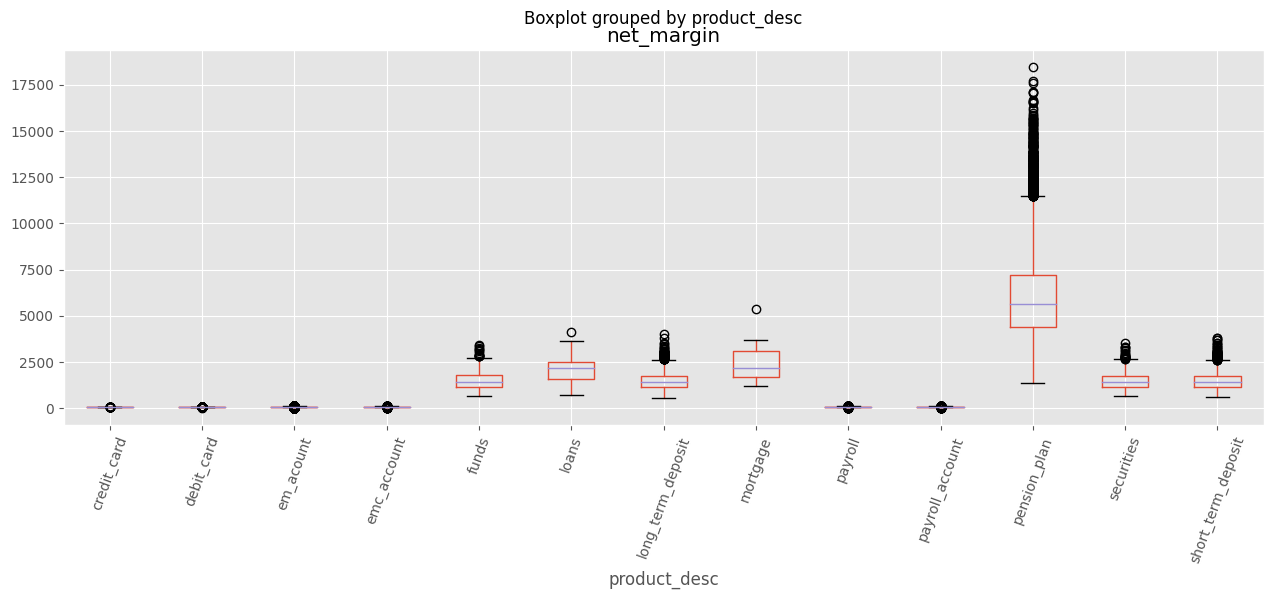

In [188]:
df_sales1.boxplot(column = "net_margin", by = "product_desc", figsize=(15,5))
plt.xticks(rotation=70);

In [189]:
df_sales1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240773 entries, 6666 to 247438
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   customer_ID     240773 non-null  object        
 1   month_sale      240773 non-null  datetime64[ns]
 2   product_ID      240773 non-null  object        
 3   net_margin      240773 non-null  float64       
 4   product_desc    240773 non-null  object        
 5   family_product  240773 non-null  object        
 6   month_sales     240773 non-null  int64         
 7   year_sales      240773 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 16.5+ MB


## Procesamiento de Customers

In [190]:
# Merge de las tablas relacionadas con el cliente
df_raw = customer_commercial_activity_raw.merge(customer_sociodemographics_raw, on=["pk_cid","pk_partition"])\
            .merge(customer_products_raw, on=["pk_cid","pk_partition"])

In [191]:
customer_commercial_activity_raw.shape

(5962924, 7)

In [192]:
customer_sociodemographics_raw.shape

(5962924, 9)

In [193]:
customer_products_raw.shape

(5962924, 18)

In [194]:
df_raw.shape

(5962924, 30)

In [195]:
# Análisis inicial de df_sales_raw y aplicamos las acciones propuestas en el análisis de los datasets

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 30 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0_x        int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   entry_date          object 
 4   entry_channel       object 
 5   active_customer     float64
 6   segment             object 
 7   Unnamed: 0_y        int64  
 8   country_id          object 
 9   region_code         float64
 10  gender              object 
 11  age                 int64  
 12  deceased            object 
 13  salary              float64
 14  Unnamed: 0          int64  
 15  short_term_deposit  int64  
 16  loans               int64  
 17  mortgage            int64  
 18  funds               int64  
 19  securities          int64  
 20  long_term_deposit   int64  
 21  em_account_pp       int64  
 22  credit_card         int64  
 23  payroll             float64
 24  pension_plan        floa

In [196]:
# Cogemos una muestra aleatoria del 10% de la base de datos

n = int(len(df_raw) * 0.1)
df1 = df_raw.sample(n)

In [197]:
df1.shape

(596292, 30)

In [198]:
#  Eliminamos las columnas "Unnamed"
df1.drop("Unnamed: 0_x", axis = 1, inplace = True)
df1.drop("Unnamed: 0_y", axis = 1, inplace = True)
df1.drop("Unnamed: 0", axis = 1, inplace = True)

In [199]:
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
df1.rename({"pk_cid": "customer_ID","pk_partition": "partition_ID"},axis='columns',inplace = True)

### Atributos de baja varianza

In [200]:
df1["em_account_p"].value_counts(normalize = True)*100

0    99.999832
1     0.000168
Name: em_account_p, dtype: float64

In [201]:
df1["em_account_pp"].value_counts(normalize = True)*100

0    100.0
Name: em_account_pp, dtype: float64

In [202]:
df1["country_id"].value_counts(normalize=True)*100

ES    99.963441
GB     0.007044
DE     0.004193
FR     0.003857
CH     0.002683
US     0.002516
BE     0.002180
BR     0.001845
MX     0.001342
VE     0.001174
IE     0.001006
PL     0.001006
IT     0.000839
MA     0.000671
SN     0.000503
AR     0.000503
RU     0.000503
CA     0.000503
CM     0.000503
QA     0.000503
LU     0.000335
CN     0.000335
ET     0.000335
CO     0.000335
CL     0.000335
SE     0.000335
JM     0.000168
SA     0.000168
CI     0.000168
MR     0.000168
DZ     0.000168
PT     0.000168
AT     0.000168
Name: country_id, dtype: float64

In [203]:
# Eliminamos variables de baja varianza
del df1['em_account_pp']
del df1['em_account_p']
del df1['country_id']

### Gestión de nulos

In [204]:
df1.isnull().sum()

customer_ID                0
partition_ID               0
entry_date                 0
entry_channel          13377
active_customer            0
segment                13439
region_code              218
gender                     2
age                        0
deceased                   0
salary                153970
short_term_deposit         0
loans                      0
mortgage                   0
funds                      0
securities                 0
long_term_deposit          0
credit_card                0
payroll                   10
pension_plan              10
payroll_account            0
emc_account                0
debit_card                 0
em_acount                  0
dtype: int64

In [205]:
# Eliminamos valores nulos de "payroll" y "pension_plan"

df1.dropna(subset = ['pension_plan'], inplace = True)

In [206]:
# Asignamos valor extremos a "salary", "gender", "region_code" ya que vamos a hacer un DecisionTree

print(df1["salary"].describe())
df1["salary"].fillna(value = 0, inplace = True)

print(df1["gender"].value_counts(normalize = True))
df1["gender"].fillna(value = 2, inplace = True)

print(df1["region_code"].describe())
df1["region_code"].fillna(value = 100, inplace = True)

count    4.423140e+05
mean     1.158461e+05
std      2.098665e+05
min      1.202730e+03
25%      6.139734e+04
50%      8.828424e+04
75%      1.312423e+05
max      2.889440e+07
Name: salary, dtype: float64
H    0.517317
V    0.482683
Name: gender, dtype: float64
count    596064.000000
mean         25.805997
std          13.588387
min           1.000000
25%          13.000000
50%          28.000000
75%          36.000000
max          52.000000
Name: region_code, dtype: float64


#### Segment ELIMINAR

In [207]:
df_segment = df1.copy()

In [208]:
df_segment[df_segment["segment"].isnull()]

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,region_code,gender,age,deceased,...,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
2508033,1454533,2018-09,2018-09,NaN,1.0,NaN,28.0,V,37,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2502544,1460433,2018-09,2018-09,NaN,0.0,NaN,30.0,V,21,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2793556,1493938,2018-10,2018-10,NaN,0.0,NaN,9.0,V,20,N,...,0,0,0,0,0.0,0.0,0,0,0,0
2498142,1442724,2018-09,2018-09,NaN,0.0,NaN,28.0,H,24,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2786141,1472118,2018-10,2018-10,NaN,0.0,NaN,45.0,H,20,N,...,0,0,0,0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493839,1453150,2018-09,2018-09,NaN,0.0,NaN,35.0,H,20,N,...,0,0,0,0,0.0,0.0,0,0,0,1
3680005,1516797,2018-12,2018-12,NaN,1.0,NaN,8.0,V,21,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2994998,1510606,2018-11,2018-11,NaN,0.0,NaN,28.0,V,21,N,...,0,0,0,0,0.0,0.0,0,0,0,0
2491839,1447973,2018-09,2018-09,NaN,0.0,NaN,46.0,V,20,N,...,0,0,0,0,0.0,0.0,0,0,0,1


In [209]:
df_segment[df_segment["customer_ID"] == 1550864]

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,region_code,gender,age,deceased,...,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount


In [210]:
df1_sorted = df_segment.sort_values(["customer_ID","partition_ID"])

In [211]:
cols = ["segment"]
df1_sorted.loc[:,cols] = df1_sorted.loc[:,cols].bfill()

In [212]:
df1[df1["segment"].isnull()]

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,region_code,gender,age,deceased,...,funds,securities,long_term_deposit,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
2508033,1454533,2018-09,2018-09,NaN,1.0,NaN,28.0,V,37,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2502544,1460433,2018-09,2018-09,NaN,0.0,NaN,30.0,V,21,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2793556,1493938,2018-10,2018-10,NaN,0.0,NaN,9.0,V,20,N,...,0,0,0,0,0.0,0.0,0,0,0,0
2498142,1442724,2018-09,2018-09,NaN,0.0,NaN,28.0,H,24,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2786141,1472118,2018-10,2018-10,NaN,0.0,NaN,45.0,H,20,N,...,0,0,0,0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493839,1453150,2018-09,2018-09,NaN,0.0,NaN,35.0,H,20,N,...,0,0,0,0,0.0,0.0,0,0,0,1
3680005,1516797,2018-12,2018-12,NaN,1.0,NaN,8.0,V,21,N,...,0,0,0,0,0.0,0.0,0,0,0,1
2994998,1510606,2018-11,2018-11,NaN,0.0,NaN,28.0,V,21,N,...,0,0,0,0,0.0,0.0,0,0,0,0
2491839,1447973,2018-09,2018-09,NaN,0.0,NaN,46.0,V,20,N,...,0,0,0,0,0.0,0.0,0,0,0,1


NICO

In [213]:
df1_nico = df1.copy()

In [214]:
df1_nico = df1_nico.groupby("partition_ID")["segment","customer_ID","partition_ID"].transform(lambda series: series.backfill().ffill())

<ipython-input-214-b9164cc619a1>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1_nico = df1_nico.groupby("partition_ID")["segment","customer_ID","partition_ID"].transform(lambda series: series.backfill().ffill())


In [215]:
df1_nico[df1_nico["customer_ID"] == 1550864 ]

,segment,customer_ID,partition_ID


In [216]:
df1_nico[df1_nico["customer_ID"] == 1416109	 ]

,segment,customer_ID,partition_ID
1931605,03 - UNIVERSITARIO,1416109,2018-08
3749120,03 - UNIVERSITARIO,1416109,2018-12


#### Segment (sustituir por valores exisitnetes en otras particiones)

In [217]:
# Array con los ids que tienen nulos en "segment"
ids_nullsegment_unique=df1[(df1['segment'].isnull()==True)]['customer_ID'].unique()

In [218]:
# Dataframe donde revisamos si en la última carga de datos hay un valor para los ids que tienen "segment" nulo. 
valores_nulos_segment=df1[(df1.customer_ID.isin(ids_nullsegment_unique))&(df1['segment'].notnull())&(df1['partition_ID']== "2019-05")][['customer_ID','segment']]

In [219]:
# Si el id con "segment" nulo tenía un valor correcto en la última partition, se lo asignaremos a los valores nulos.
dict_nulos_segment=dict(zip(valores_nulos_segment['customer_ID'],valores_nulos_segment['segment']))

#### Entry_Chanel (sustituir por valores exisitnetes en otras particiones)

In [220]:
# Array con los ids que tienen nulos en "entry_channel"
ids_nullentrychannel_unique=df1[(df1['entry_channel'].isnull()==True)]['customer_ID'].unique()

In [221]:
len(ids_nullentrychannel_unique)

13364

In [222]:
# Dataframe donde revisamos si en la última carga de datos hay un valor para los ids que tienen "entry_channel" nulo. 
valores_nulos_entrychannel=df1[(df1.customer_ID.isin(ids_nullentrychannel_unique))&(df1['entry_channel'].notnull())&(df1['partition_ID']=='2019-05')][['customer_ID','entry_channel']]

In [223]:
# Si el id con "entry_channel" nulo tenía un valor correcto en la última partition, se lo asignaremos a los valores nulos.
dict_nulos_entrychannel=dict(zip(valores_nulos_entrychannel['customer_ID'],valores_nulos_entrychannel['entry_channel']))

In [224]:
df1.set_index('customer_ID',inplace = True)

In [225]:
# Imputamos los últimos valores registrados correctamente en "segment" y "entry_channel"
df1['segment'].fillna(dict_nulos_segment,inplace=True)
df1['entry_channel'].fillna(dict_nulos_entrychannel,inplace=True)

In [226]:
df1.isnull().sum()

partition_ID              0
entry_date                0
entry_channel         12162
active_customer           0
segment               12217
region_code               0
gender                    0
age                       0
deceased                  0
salary                    0
short_term_deposit        0
loans                     0
mortgage                  0
funds                     0
securities                0
long_term_deposit         0
credit_card               0
payroll                   0
pension_plan              0
payroll_account           0
emc_account               0
debit_card                0
em_acount                 0
dtype: int64

In [227]:
# Imputación de valores extremos a los nulos que no se han podido deducir por el histórico
df1['segment'].fillna(value='04 - NO SEGMENT',inplace=True)
df1['entry_channel'].fillna(value='ZZZ',inplace=True)

In [228]:
df1.isnull().sum()

partition_ID          0
entry_date            0
entry_channel         0
active_customer       0
segment               0
region_code           0
gender                0
age                   0
deceased              0
salary                0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
long_term_deposit     0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
dtype: int64

### Transformación de fechas

In [229]:
# Extraemos año, mes y trimestre de partition ID
df1['partition_date'] = pd.to_datetime(df1['partition_ID'])

df1['partition_year'] = df1['partition_date'].dt.year
df1['partition_month'] = df1['partition_date'].dt.month
df1['partition_quarter'] = df1['partition_date'].dt.quarter

In [230]:
# Definimos las primary keys como índice
df1.reset_index(inplace = True)
df1.set_index(["customer_ID","partition_ID"],inplace = True)

In [231]:
# Transformamos "entry_date" a fecha y extraemos año, mes y trimestre
df1['entry_date']=pd.to_datetime(df1['entry_date'])

df1['entry_year'] = df1['entry_date'].dt.year
df1['entry_month'] = df1['entry_date'].dt.month
df1['entry_quarter'] = df1['entry_date'].dt.quarter

### Tranformación de numéricas

In [232]:
# Cambiamos el type de las variables con float a int (active_customer, payroll y pension_plan), excepto salary, que si que es float

variables_to_int = ['active_customer', 'payroll', 'pension_plan']

df1[variables_to_int] = df1[variables_to_int].applymap(int)

### Transformación de categóricas

In [233]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [234]:
# OHE "entry_channel"

df1 = OHE(df1, "entry_channel")

In [235]:
# OHE segment

df1 = OHE(df1, "segment")

In [236]:
# OHE segment

df1 = OHE(df1, "region_code")

In [237]:
# gender --> 1 = Hembras, 0 = Varones, 2 = Nulos

df1["gender"] = df1["gender"].replace("H", 1) # H es de Hembras
df1["gender"] = df1["gender"].replace("V", 0) # V es de Varones

In [238]:
# deceased --> 1 = Fallecido, 0 = No fallecido

df1["deceased"] = df1["deceased"].replace("N", 0) # H es de Hembras
df1["deceased"] = df1["deceased"].replace("S", 1) # H es de Hembras

In [239]:
df1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 596282 entries, (1215289, '2019-03') to (1029154, '2018-09')
Data columns (total 142 columns):
 #    Column                      Dtype         
---   ------                      -----         
 0    entry_date                  datetime64[ns]
 1    active_customer             int64         
 2    gender                      int64         
 3    age                         int64         
 4    deceased                    int64         
 5    salary                      float64       
 6    short_term_deposit          int64         
 7    loans                       int64         
 8    mortgage                    int64         
 9    funds                       int64         
 10   securities                  int64         
 11   long_term_deposit           int64         
 12   credit_card                 int64         
 13   payroll                     int64         
 14   pension_plan                int64         
 15   payroll_account 

## Partición train/test/validation

In [240]:
df = df1.copy()

In [241]:
df.drop(["entry_date", "partition_date"],axis = 1,inplace = True)

In [242]:
df.shape

(596282, 140)

In [243]:
# La partición de validación tiene que ser lo más parecida a la realidad posible, un % del dataset siempre mayor de 1000 filas. tenemos 596.284 en total, si cogemos 10% son 59.000 filas para validación

In [244]:
# Calcula los tamaños de cada partición
validation_size = int(len(df) * 0.1)
development_size = int(len(df) * 0.9)

In [245]:
# Asigna los datos a las particiones
val_df = df[:validation_size]
dev_df = df[validation_size:]


In [246]:
val_df_y = val_df[[TARGET]]

val_df_X = val_df.drop(TARGET,axis=1)

In [247]:
dev_df_y = dev_df[[TARGET]]

dev_df_x = dev_df.drop(TARGET,axis=1)

### Train y Test

In [248]:
#20% del dataset de development para test

In [249]:
X_train, X_test, y_train, y_test = model_selection.train_test_split( dev_df_x, dev_df_y, test_size=0.2, random_state=42)

In [250]:
#Comprobar que la distribución de ambas particiones es parecida (media, percentiles y distrribución std). Si no lo es, cambiamos el random state o utilizamos k.fold

In [251]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
active_customer,429323.0,0.401190,0.490140,0.0,0.0,0.00,1.00,1.00
gender,429323.0,0.517307,0.499710,0.0,0.0,1.00,1.00,2.00
age,429323.0,29.725521,11.945958,2.0,22.0,25.00,34.00,104.00
deceased,429323.0,0.000214,0.014637,0.0,0.0,0.00,0.00,1.00
salary,429323.0,85800.673132,188125.441243,0.0,0.0,69107.28,112716.03,28894395.51


In [252]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
active_customer,107331.0,0.402167,0.490338,0.0,0.0,0.00,1.00,1.00
gender,107331.0,0.517101,0.499710,0.0,0.0,1.00,1.00,1.00
age,107331.0,29.758364,11.961947,2.0,22.0,25.00,34.00,104.00
deceased,107331.0,0.000140,0.011821,0.0,0.0,0.00,0.00,1.00
salary,107331.0,86354.432463,184257.919121,0.0,0.0,69127.98,113017.08,28894395.51


# 4.- Modelling

## Decission Tree

In [258]:
#Instanciamos el modelo
dt=DecisionTreeClassifier(max_depth=6,random_state=42, min_samples_leaf=500)

In [259]:
#lo entrenamos con el dataset de train
dt.fit(X=X_train,y=y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=500, random_state=42)

In [268]:
#lo pintamos
tree_data=export_graphviz(
    decision_tree=dt,
    out_file=None, 
    max_depth=None,
    feature_names=X_test.columns,
    class_names=['no_pension_plan','pension_plan'],
    label="all",
    filled=True,
    leaves_parallel=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate=True,
    rounded=True,
    special_characters=False,
    precision=3,
    fontname="helvetica",
)

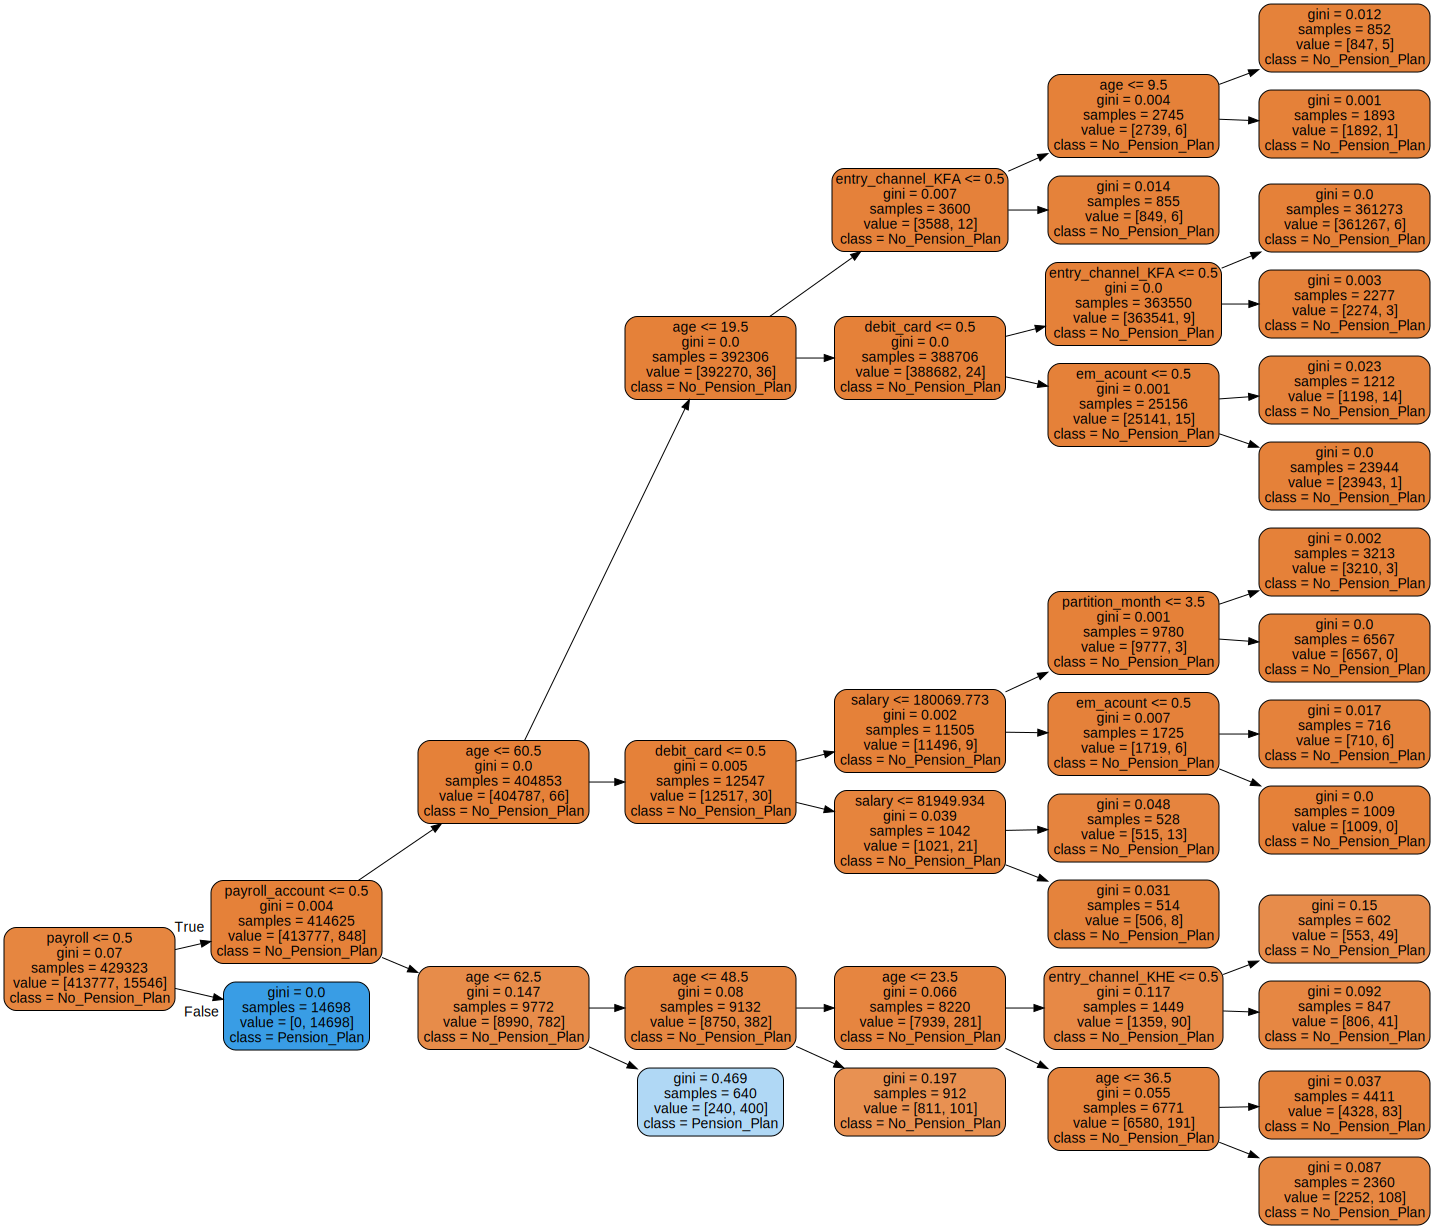

In [267]:
graphviz.Source(tree_data)

In [270]:
#generamos predicciones y evaluamos el modelo
y_test_pred = pd.DataFrame(dt.predict(X_test),index=y_test.index,columns=['pension_plan_prediction'])

In [271]:
#join de y_test y y_test_pred para comparar el resultado real con la predicción
result_df=y_test.join(y_test_pred,how='inner')

In [272]:
result_df['Success']=(result_df['pension_plan']==result_df['pension_plan_prediction']).astype(int)

In [273]:
result_df.head(20)

,,pension_plan,pension_plan_prediction,Success
customer_ID,partition_ID,,,
1065960,2018-03,0,0,1
1487879,2018-10,0,0,1
1496064,2019-04,0,0,1
1412702,2019-04,0,0,1
1178685,2019-01,0,0,1
1507351,2019-01,0,0,1
1286856,2019-04,0,0,1
1097652,2018-02,0,0,1
1346461,2018-02,0,0,1


In [274]:
#Accuracy
result_df['Success'].mean()

0.9984440655542202

In [255]:
#Compruebo que el accuracy es mayor de la media del target 3,65% (modelo más tonto, que siempre predice 0, predice 96,35%)

## Confusion matrix

In [276]:
confusion_matrix=pd.crosstab(result_df['pension_plan'],result_df['pension_plan_prediction'])

In [277]:
TP=confusion_matrix.iloc[1,1]
TN=confusion_matrix.iloc[0,0]
FP=confusion_matrix.iloc[0,1]
FN=confusion_matrix.iloc[1,0]

In [278]:
confusion_matrix
# Parece que el modelo tiende a dar más falsos positivos, pero aproximadamente está  balanceado entre FP y FN

pension_plan_prediction,0,1
pension_plan,,
0,103447,56
1,111,3717


In [279]:
dt.score(X_test,y_test)

0.9984440655542202

In [280]:
#generamos las predicciones del dataset de test pero como probabilidades
dt.predict_proba(X_test)

array([[9.99983392e-01, 1.66079391e-05],
       [9.99983392e-01, 1.66079391e-05],
       [9.99983392e-01, 1.66079391e-05],
       ...,
       [9.99983392e-01, 1.66079391e-05],
       [9.99983392e-01, 1.66079391e-05],
       [9.99958236e-01, 4.17641163e-05]])

In [282]:
#seleeciono las probabilidades de #1 y lo convierto en un dataframe
y_score= pd.DataFrame(dt.predict_proba(X_test)[:,1],index=y_test.index, columns=['pension_plan_score'])

In [283]:
# lo combino con el dataframe anterior
result_df= result_df.join(y_score)

In [284]:
result_df.head(10)

,,pension_plan,pension_plan_prediction,Success,pension_plan_score
customer_ID,partition_ID,,,,
1065960,2018-03,0,0,1,0.000017
1487879,2018-10,0,0,1,0.000017
1496064,2019-04,0,0,1,0.000017
1412702,2019-04,0,0,1,0.000017
1178685,2019-01,0,0,1,0.000017
1507351,2019-01,0,0,1,0.000017
1286856,2019-04,0,0,1,0.000017
1097652,2018-02,0,0,1,0.000017
1346461,2018-02,0,0,1,0.000017


## F1 Score

In [285]:
# Desarrollo matemático de F1Score
Precision=TP/ (TP+FP)
Recall= TP/(TP+FN)
f1_score=2/(1/Precision+1/Recall)

In [286]:
# Precision = Cuántos positivos de los que detecta realmente lo son (según la confusion matrix, la precision será algo más baja)
# Recall alta = Cuántos positivos detecta el modelo del total

In [287]:
Precision

0.9851576994434137

In [289]:
Recall

0.9710031347962382

In [288]:
metrics.f1_score(y_test,y_test_pred)

0.978029206683331

## AUC y ROC curve

In [291]:
metrics.roc_auc_score(result_df['pension_plan'],result_df['pension_plan_score'])

0.9987886748818966

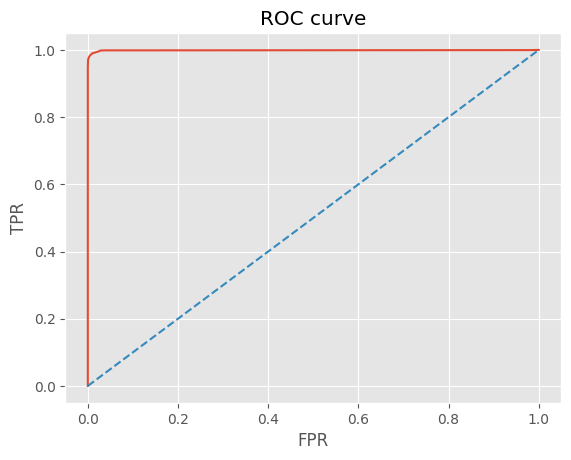

In [292]:
fpr,tpr,th=metrics.roc_curve(result_df['pension_plan'],result_df['pension_plan_score'])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()


## Control del overfitting

In [293]:
for i in range(1,15):
  #instancio el modelo
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42)
  #entreno el modelo
  dt2.fit(X_train,y_train)
  #evaluo 
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)
  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,3)},Acc.test: {np.round(acc_test,3)}')

Profundidad de arbol: 1, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 2, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 3, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 4, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 5, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 6, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 7, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 8, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 9, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 10, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 11, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 12, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 13, Acc.train: 0.999,Acc.test: 0.998
Profundidad de arbol: 14, Acc.train: 0.999,Acc.test: 0.998


In [294]:
#puedo probar con diferent numero de observaciones en el nodo final
for i in range(1,15):
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42,min_samples_split=500)
  dt2.fit(X_train,y_train)
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)


  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,3)},Acc.test: {np.round(acc_test,3)}')

Profundidad de arbol: 1, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 2, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 3, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 4, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 5, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 6, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 7, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 8, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 9, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 10, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 11, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 12, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 13, Acc.train: 0.998,Acc.test: 0.998
Profundidad de arbol: 14, Acc.train: 0.998,Acc.test: 0.998


## Modelos alternativos

In [295]:
from sklearn.ensemble import RandomForestClassifier

In [296]:
#Random Forest con 10 replicas
rf = RandomForestClassifier (max_depth=11,random_state=42,min_samples_split=500,n_estimators=10)

In [297]:
rf.fit(X_train,y_train)

<ipython-input-297-d6d9475b85dc>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train,y_train)


RandomForestClassifier(max_depth=11, min_samples_split=500, n_estimators=10,
                       random_state=42)

In [298]:
rf.score(X_test,y_test)
# Se pierde 1 centesima en Accuracy usando el random forest

0.9974657834176519

In [ ]:
'''Como el dataset sobre el que tiramos el modelo es lo suficientemente grande,
el Random Forest saca una Acc muy similar. Modelos alternativos como el Random Forest o el XGBoost
son útiles para datasets que se puedan quedar cortos en datos'''

## Variables más predictivas

In [299]:
top_features = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [300]:
top_features
# Aquí vemos las variables que el modelo ha considerado como más predictivas

payroll                       0.491183
payroll_account               0.239741
debit_card                    0.095719
em_acount                     0.051384
active_customer               0.049332
credit_card                   0.024203
entry_channel_KHE             0.011779
segment_03 - UNIVERSITARIO    0.008068
age                           0.006313
emc_account                   0.004881
entry_channel_RED             0.003470
region_code_28.0              0.001752
entry_channel_KFC             0.001574
salary                        0.001242
entry_month                   0.001142
segment_02 - PARTICULARES     0.001026
entry_year                    0.000889
segment_01 - TOP              0.000692
entry_channel_KFA             0.000662
entry_channel_KHQ             0.000404
dtype: float64